In [1]:
import sys
import getpass
import os

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

#Geo Imports
import geopandas as gp
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection

# EIR Growth Summaries

## Table of Contents 


## Pre-Processing Steps <a name='preprocessing'><a/>

In [2]:
#Create GIS client using internal portal credentials 
password = os.environ.get('portal_pass')
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

In [3]:
#Pull growth geographies from portal
growth_geo_gdf = pull_geodata_from_argis('3922afc70d3a4475a98e6ae9973f2bfb',client=gis)

In [4]:
growth_geo_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
growth_geo_gdf.shape

(4636, 7)

In [6]:
#Pull counties from portal
bay_counties_gdf = pull_geodata_from_argis('0f39d9cf0b4f4b1380282315b09d5a23',client=gis)

In [7]:
bay_counties_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
bay_counties_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       9 non-null      int64   
 1   id             9 non-null      float64 
 2   feattyp        9 non-null      int64   
 3   order00        9 non-null      object  
 4   order01        9 non-null      object  
 5   order02        9 non-null      object  
 6   order03        9 non-null      object  
 7   order04        9 non-null      object  
 8   order05        9 non-null      object  
 9   order06        9 non-null      object  
 10  order07        9 non-null      object  
 11  order08        9 non-null      object  
 12  featarea       9 non-null      float64 
 13  featperim      9 non-null      float64 
 14  name           9 non-null      object  
 15  namelc         9 non-null      object  
 16  popclass       9 non-null      int64   
 17  pop            9 non-null      

## Dissolve growth geographies into one feature

In [35]:
#Create dissolve field
growth_geo_gdf['gg'] = True

In [36]:
growth_geo_gdf.head(5)

,SHAPE__Area,SHAPE__Length,area_name,designatio,jurisdicti,objectid,geom,gg
0,0.001593,0.409479,Hayward PPA,Priority Production Area,Hayward,1,"MULTIPOLYGON (((-122.07662 37.61741, -122.0745...",True
1,0.000468,0.156762,Pacific Commons Priority Production Area,Priority Production Area,Fremont,2,"MULTIPOLYGON (((-121.96581 37.50549, -121.9641...",True
2,0.000636,0.166956,Bayside Industrial Priority Production Area,Priority Production Area,Fremont,3,"MULTIPOLYGON (((-121.94969 37.49213, -121.9496...",True
3,0.000124,0.045386,Westside PPA,Priority Production Area,Livermore,4,"MULTIPOLYGON (((-121.81473 37.67526, -121.8145...",True
4,0.000040,0.028528,Western Concord PPA,Priority Production Area,Concord,5,"MULTIPOLYGON (((-122.02708 37.95350, -122.0270...",True


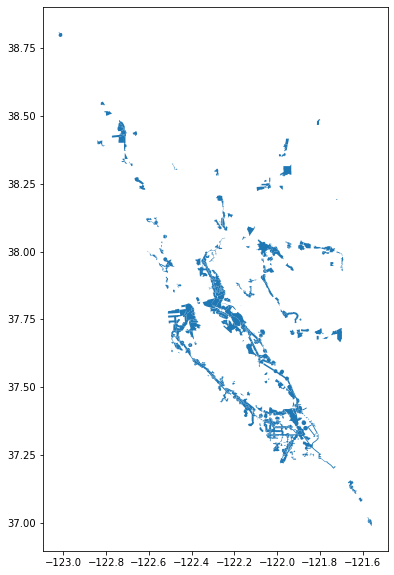

In [38]:
growth_geo_gdf.plot(figsize=(10,10));

In [39]:
growth_geo_gdf.shape

(4636, 8)

In [40]:
#Dissolve growth geography by dissolve field 
growth_geo_diss_gdf = growth_geo_gdf[['gg','geom']].dissolve(by='gg').reset_index()

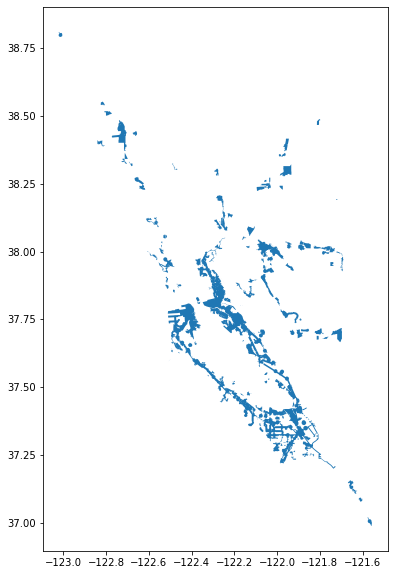

In [41]:
growth_geo_diss_gdf.plot(figsize=(10,10));

In [42]:
growth_geo_diss_gdf.shape

(1, 2)

## Overlay Counties and TPAs

In [43]:
growth_geo_cty = gp.overlay(bay_counties_gdf[['name','geom']],growth_geo_diss_gdf,how='identity')

In [44]:
growth_geo_cty.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      18 non-null     object  
 1   gg        9 non-null      object  
 2   geometry  18 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 560.0+ bytes


In [45]:
growth_geo_cty.head(5)

,name,gg,geometry
0,Sonoma,True,"MULTIPOLYGON (((-122.48712 38.32621, -122.4870..."
1,Marin,True,"MULTIPOLYGON (((-122.46116 37.86919, -122.4622..."
2,Napa,True,"MULTIPOLYGON (((-122.25148 38.15528, -122.2521..."
3,San Mateo,True,"MULTIPOLYGON (((-122.12684 37.47531, -122.1266..."
4,San Francisco,True,"MULTIPOLYGON (((-122.50761 37.75661, -122.5077..."


In [46]:
#Fill nan values with False
growth_geo_cty['gg'] = growth_geo_cty['gg'].fillna(value=False)

## Summarize by county and tpa

Geodataframe should be projected to WGS84 UTM Z 10N (EPSG:32610), staying in the WGS datum to avoid datum transformation step

In [47]:
growth_geo_cty_proj = growth_geo_cty.to_crs(crs=('EPSG:32610'))

In [48]:
growth_geo_cty_proj.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
growth_geo_cty_proj['acres'] = growth_geo_cty_proj['geometry'].area * 0.0002471054

In [50]:
growth_geo_cty_proj.head(5)

,name,gg,geometry,acres
0,Sonoma,True,"MULTIPOLYGON (((544829.347 4242133.916, 544837...",12452.118148
1,Marin,True,"MULTIPOLYGON (((547393.173 4191437.801, 547293...",6748.378610
2,Napa,True,"MULTIPOLYGON (((565580.011 4223308.661, 565519...",2080.720237
3,San Mateo,True,"MULTIPOLYGON (((577204.620 4147960.449, 577218...",19929.436689
4,San Francisco,True,"MULTIPOLYGON (((543373.553 4178925.234, 543365...",19569.639734


In [52]:
growth_geo_cty_proj[growth_geo_cty_proj['gg'] == False]

,name,gg,geometry,acres
9,Sonoma,False,"MULTIPOLYGON (((557234.888 4214144.224, 556086...",1.118147e+06
10,Marin,False,"MULTIPOLYGON (((542527.256 4186465.538, 542447...",5.228924e+05
11,Napa,False,"MULTIPOLYGON (((568245.024 4223298.910, 567422...",5.021428e+05
12,San Mateo,False,"MULTIPOLYGON (((548497.374 4173584.990, 548497...",4.539734e+05
13,San Francisco,False,"MULTIPOLYGON (((539474.575 4173435.690, 538543...",6.750145e+04
14,Santa Clara,False,"MULTIPOLYGON (((573284.219 4143867.045, 573284...",7.767125e+05
15,Alameda,False,"MULTIPOLYGON (((560772.128 4194023.223, 560781...",4.614262e+05
16,Contra Costa,False,"MULTIPOLYGON (((556194.293 4196029.569, 556194...",4.775421e+05
17,Solano,False,"MULTIPOLYGON (((574870.769 4209676.664, 574861...",5.661542e+05


In [64]:
growth_geo_cty_proj_sum = (growth_geo_cty_proj[['name','gg','acres']]
                           .groupby(['name','gg'])
                           .aggregate(func='sum').reset_index())

In [65]:
growth_geo_cty_proj_sum

,name,gg,acres
0,Alameda,False,4.614262e+05
1,Alameda,True,6.377241e+04
2,Contra Costa,False,4.775421e+05
3,Contra Costa,True,3.733992e+04
4,Marin,False,5.228924e+05
5,Marin,True,6.748379e+03
6,Napa,False,5.021428e+05
7,Napa,True,2.080720e+03
8,San Francisco,False,6.750145e+04
9,San Francisco,True,1.956964e+04


In [82]:
#Pivot to keep county names as index and growth geography/tpa acre sums as values
growth_geog_piv = growth_geo_cty_proj_sum.pivot(index='name', columns='gg', values='acres').reset_index()